# SVHN Digits Localization Pipeline

## Imporing Libraries

In [1]:
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils

## Reading Image

13296


(92, 244, 3)

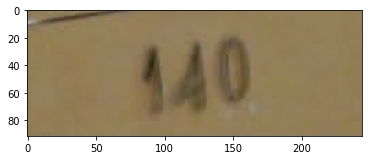

In [2]:
i = random.randint(1,33402)
print(i)
img = cv2.imread(f'data/train/{i}.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
height = img.shape[0]
width = img.shape[1]
img.shape

## Smoothing Using Balateral Filter

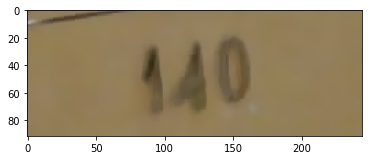

In [3]:
bfilter= cv2.bilateralFilter(img,11,17,17) #Better than gaussian because it keeps edges sharp
plt.imshow(cv2.cvtColor(bfilter,cv2.COLOR_BGR2RGB))

## Convering to Grayscale

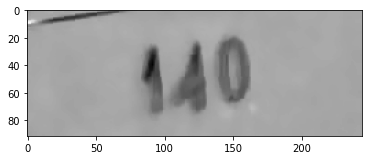

In [4]:
gray = cv2.cvtColor(bfilter,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')

## Calculating Histogram of Grayscale Image

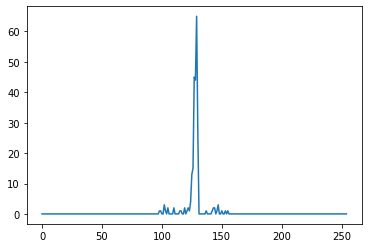

In [5]:
hist = cv2.calcHist(gray,[0],None,[255],[0,255])
plt.plot(hist)

## Applying Histogram Equalization and Constrast Stretching

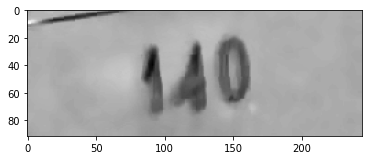

In [6]:
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(5,5))
cl1 = clahe.apply(gray)
plt.imshow(cl1,cmap='gray')

## Plotting Equalized Histrogram

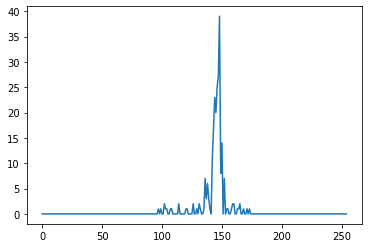

In [7]:
hist = cv2.calcHist(cl1,[0],None,[255],[0,255])
plt.plot(hist)

## Canny Edge Detection

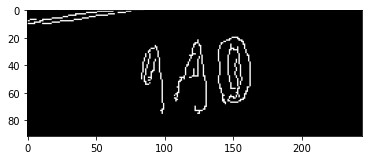

In [8]:
edges = cv2.Canny(cl1,30,150)
plt.imshow(edges,cmap='gray')

## Grabbing Contours

11

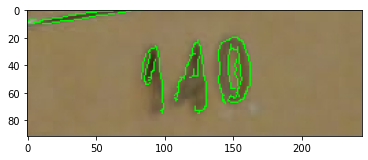

In [9]:
keypoints= cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours=imutils.grab_contours(keypoints)
edged_cont = cv2.drawContours(img.copy(), contours, -1, (0,255,0), 1)
plt.imshow(cv2.cvtColor(edged_cont,cv2.COLOR_BGR2RGB))
sorted_contours=sorted(contours,key=cv2.contourArea,reverse=True)
len(sorted_contours)

## Grabbing Bounding Rectangles and Filtering Them

[[139, 20, 163, 69], [107, 22, 131, 76], [85, 26, 100, 76], [146, 25, 157, 58]]

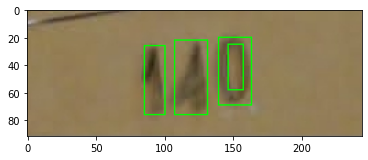

In [10]:
pred_contours = []
pred_boxes = img.copy()
for contour in sorted_contours:
    [x, y, w, h] = cv2.boundingRect(contour)
    if ( (h*w > 0.015*height*width) and (y<0.5*height) and (0.25*width< x <0.75*width)):
        pred_contours.append([x, y, x+w, y+h])
        cv2.rectangle(pred_boxes, (x,y), (x+w,y+h), (0,255,0), 1)
plt.imshow(cv2.cvtColor(pred_boxes,cv2.COLOR_BGR2RGB))

pred_contours

## Defining a Function to Calculate Intersection Over Uinion Between 2 Boxes

In [11]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

## Defining a Function to Remove Duplicated Contours

In [12]:
def removeDuplicateContours(pred_contours):
    # Corner Case: Image has only 1 digit and 1 contour predicted 
    if(len(pred_contours)==1):
        return pred_contours
    
    
    filtered_contours = []
    #pred_contours = [list(x) for x in set([tuple(L) for L in pred_contours])]
    i=0
    while(i<len(pred_contours)):
        filtered_contours.append(pred_contours[i])
        # Corner Case: Last two contours are not duplicates
        if i == len(pred_contours)-1:
            break    
        j=i+1
        while(j<len(pred_contours)):
            iou = bb_intersection_over_union(pred_contours[i], pred_contours[j])
            if iou>0.8:
                pred_contours.pop(j)  
            j+=1
        i+=1     
    return filtered_contours
    """
    i=0
    while(i<len(pred_contours)-1):
        iou = bb_intersection_over_union(pred_contours[i], pred_contours[i+1])
        if iou>0.8:
            filtered_contours.append(pred_contours[i])
            i+=1
        else:
            filtered_contours.append(pred_contours[i])
        i+=1
    return filtered_contours
    """

## Removing Dublicated Contours

In [13]:
filtered_contours = removeDuplicateContours(pred_contours)

filtered_contours

[[139, 20, 163, 69], [107, 22, 131, 76], [85, 26, 100, 76], [146, 25, 157, 58]]

## Reading DigitStruct json file and Analysing its Head

In [14]:
digitStruct = pd.read_json('data/train/digitStruct.json')

digitStruct.set_index('filename', inplace=True)

digitStruct.head()

,boxes
filename,
1.png,"[{'height': 219.0, 'label': 1.0, 'left': 246.0..."
2.png,"[{'height': 32.0, 'label': 2.0, 'left': 77.0, ..."
3.png,"[{'height': 15.0, 'label': 2.0, 'left': 17.0, ..."
4.png,"[{'height': 34.0, 'label': 9.0, 'left': 57.0, ..."
5.png,"[{'height': 46.0, 'label': 3.0, 'left': 52.0, ..."


## Defining a Function to Grab Ground Truth Bounding Boxes

In [15]:
def get_gt_contours(i):
    gt_contours = []
    boxes = digitStruct.loc[f'{str(i)}.png', 'boxes']
    for box in boxes:
        x = box['left']
        y = box['top']
        w = box['width']
        h = box['height']
        gt_contours.append([x, y, x+w, y+h])
    return gt_contours

## Grabbing Ground Truth Bounding Boxes

In [16]:
gt_contours = get_gt_contours(i)
print(len(gt_contours))
gt_contours

3


[[82.0, 23.0, 104.0, 79.0],
 [103.0, 20.0, 135.0, 76.0],
 [133.0, 14.0, 171.0, 70.0]]

## Plotting Ground Truth Bounding Boxes

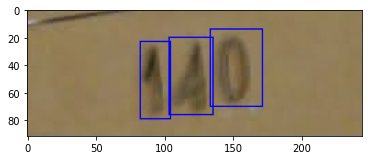

In [17]:
gt_boxes = img.copy()
for contour in gt_contours:
    contour = list(map(int, contour)) # To cast all point values to integers (loaded from json file as float)
    [x1, y1, x2, y2] = contour
    cv2.rectangle(gt_boxes, (x1,y1), (x2,y2), (255,0,0), 1)
plt.imshow(cv2.cvtColor(gt_boxes, cv2.COLOR_BGR2RGB))

## Finding Matching Contours

In [18]:
match_contours = []
for contour in filtered_contours:
    for gt_contour in gt_contours:
        iou = bb_intersection_over_union(contour, gt_contour)
        if iou > 0.4:
            match_contours.append({'box': contour, 'iou':iou})

print(len(match_contours))
match_contours


3


[{'box': [139, 20, 163, 69], 'iou': 0.5623031938821412},
 {'box': [107, 22, 131, 76], 'iou': 0.7309941520467836},
 {'box': [85, 26, 100, 76], 'iou': 0.6224256292906178}]

## Handling Corner Case: Matched contours > the actual digits in image

In [19]:
# Corner Case: Matched contours > the actual digits in image ()
if len(match_contours) > len(gt_contours):
    match_contours = sorted(match_contours, key=lambda c: c['iou'], reverse=True)
    match_contours = match_contours[:len(gt_contours)]
match_contours

[{'box': [139, 20, 163, 69], 'iou': 0.5623031938821412},
 {'box': [107, 22, 131, 76], 'iou': 0.7309941520467836},
 {'box': [85, 26, 100, 76], 'iou': 0.6224256292906178}]

## Plotting Matching Contours

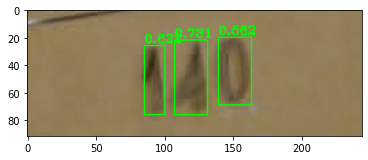

In [20]:
match_boxes = img.copy()
for contour in match_contours:
    [x1, y1, x2, y2] = contour['box']
    cv2.rectangle(match_boxes, (x1,y1), (x2,y2), (0,255,0), 1)
    
    cv2.putText(match_boxes, "{:.3f}".format(contour['iou']), (x1, y1-2), cv2.FONT_HERSHEY_TRIPLEX, 0.3, (0, 255, 0), 1)

plt.imshow(cv2.cvtColor(match_boxes, cv2.COLOR_BGR2RGB))

## Calculating Recall, Precision, and F1-Score

In [21]:
true_pos = len(match_contours)
false_pos = len(filtered_contours) - len(match_contours)
false_neg = len(gt_contours) - len(match_contours)

precision = true_pos / (true_pos + false_pos)

recall = true_pos / (true_pos + false_neg)

if true_pos == 0:
    f1_score = 0
else:
    f1_score = (2*precision*recall) / (precision+recall)

print(f"Total Precision: {precision*100:0.3f}%")
print(f"Total Recall: {recall*100:0.3f}%")
print(f"Total F1-Score: {f1_score*100:0.3f}%")

Total Precision: 75.000%
Total Recall: 100.000%
Total F1-Score: 85.714%
